# Day 16 Analysis

Yesterday I compared Tyreek Hill's 2022 season through Week 9 with Calvin Johnson's (Megatron) record-setting 2012 season. Today I'm going to compare Tyreek Hill to 10 "peers". We know he has the most receiving yards but it he beating other top players on a weekly basis? Or is there a lot of variance to his production?

I'm going to determine his peers by first looking at which players had multiple top 5 performances (by receiving yards) through Week 9. If that doesn't produce 10 players (other than Tyreek), I'll look at other stats.

## Set Up

In [25]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Create database connection
conn = sqlite3.connect('../../data/db/database.db')

## Top WRs in 2022

In [60]:
query = """
WITH data AS (
    SELECT
        player_display_name AS player_name,
        week,
        receiving_yards AS rec_yds,
        receiving_tds AS rec_tds,
        receiving_air_yards AS rec_air_yds,
        ROUND(fantasy_points,2) AS pts,
        ROUND(fantasy_points_ppr,2) AS pts_ppr,
        COUNT() OVER(PARTITION BY player_id) AS num_games,
        RANK() OVER(PARTITION BY week ORDER BY receiving_yards DESC) AS r_rec_yds,
        RANK() OVER(PARTITION BY week, position ORDER BY fantasy_points_ppr DESC) AS r_pts_ppr
    FROM weekly 
    WHERE season = 2022
        AND week <= 9
        AND season_type = 'REG'
)
SELECT *
FROM data
ORDER BY week, r_rec_yds ASC
"""

df_2022 = pd.read_sql(query, conn)

print(df_2022.shape)
df_2022.head()

(2690, 10)


,player_name,week,rec_yds,rec_tds,rec_air_yds,pts,pts_ppr,num_games,r_rec_yds,r_pts_ppr
0,Justin Jefferson,1,184.0,2,118.0,30.4,39.4,8,1,1
1,A.J. Brown,1,155.0,0,94.0,15.5,25.5,8,2,7
2,Davante Adams,1,141.0,1,177.0,20.1,30.1,8,3,3
3,Ja'Marr Chase,1,129.0,1,108.0,18.9,28.9,7,4,4
4,Cooper Kupp,1,128.0,1,116.0,18.8,31.8,8,5,2


In [61]:
# Subset to the top 5 performers per week
df_top5_by_week = df_2022[df_2022['r_rec_yds'] <= 5]

In [62]:
df_top5_by_week['player_name'].value_counts()[:15]

Tyreek Hill                 5
Justin Jefferson            4
Davante Adams               3
Ja'Marr Chase               3
Cooper Kupp                 3
Jaylen Waddle               2
Stefon Diggs                2
A.J. Brown                  2
Chris Olave                 2
Marquez Valdes-Scantling    1
Tyler Boyd                  1
JuJu Smith-Schuster         1
Amari Cooper                1
DeAndre Hopkins             1
D.J. Moore                  1
Name: player_name, dtype: int64

So we have 9 players (including Tyreek) who have at least two appearances in the top 5 rankings for receiving yards. Let's get 2 other players so we can compare Tyreek and the next best 10 guys. Let's compare the stats of these players with only 1 top 5 appearance

In [63]:
# From the value counts, get the names of the players with only 1 top 5 appearance
# Subset the data
filter = df_top5_by_week['player_name'].value_counts() == 1

players_one_top5 = df_top5_by_week['player_name'].value_counts()[filter].index

players_one_top5

Index(['Marquez Valdes-Scantling', 'Tyler Boyd', 'JuJu Smith-Schuster',
       'Amari Cooper', 'DeAndre Hopkins', 'D.J. Moore', 'Mike Williams',
       'Travis Kelce', 'Michael Pittman', 'Marquise Brown', 'Gabe Davis',
       'Tee Higgins', 'DK Metcalf', 'T.J. Hockenson', 'DeVante Parker',
       'Mack Hollins', 'DeVonta Smith', 'Amon-Ra St. Brown',
       'Courtland Sutton', 'Josh Palmer'],
      dtype='object')

In [72]:
# Get season averages for these players to look for consistency
season_one_top5 = df_2022[df_2022['player_name'].isin(players_one_top5)]\
                    .groupby('player_name')[['rec_yds', 'num_games', 'r_pts_ppr']]\
                    .mean()\
                    .sort_values(['rec_yds'], ascending=False)\
                    .reset_index()\
                    .round(2)
season_one_top5.head()

,player_name,rec_yds,num_games,r_pts_ppr
0,DeAndre Hopkins,99.33,3.0,10.33
1,Travis Kelce,82.38,8.0,3.88
2,Marquise Brown,80.83,6.0,19.33
3,JuJu Smith-Schuster,72.75,8.0,34.75
4,Mike Williams,70.71,7.0,36.43


Even though Hopkins has only 3 games played, I expect his average to stay around this mark since he is the WR1 in the Arizona offense. Funny to see Travis Kelce (a Tight End!) pop up but not totally surprising since Kansas City uses him like a WR.

With these two players added, we can now compare Tyreek Hill's receiving yards to his top 10 "peers" in the stat. How does he rank week to week?

In [65]:
# Assemble the peer list - the 10 players that challenge Tyreek Hill when it comes to receiving yards
top_10_peers = list(df_top5_by_week['player_name'].value_counts()[df_top5_by_week['player_name'].value_counts() != 1].index)
top_10_peers.pop(0) # remove Tyreek

# Add Hopkins and Kelce
for player in list(season_one_top5['player_name'])[:2]:
    top_10_peers.append(player)

# Validate
print(len(top_10_peers))
top_10_peers

10


['Justin Jefferson',
 'Davante Adams',
 "Ja'Marr Chase",
 'Cooper Kupp',
 'Jaylen Waddle',
 'Stefon Diggs',
 'A.J. Brown',
 'Chris Olave',
 'DeAndre Hopkins',
 'Travis Kelce']

In [66]:
# Assemble the dataset for peers
top_10_peers_by_week = df_2022[df_2022['player_name'].isin(top_10_peers)]\
                    .groupby('week')\
                    .mean()\
                    .reset_index()\
                    .round(3)
top_10_peers_by_week

/var/folders/pr/phs5jp1d143fx1t05hqzwt580000gn/T/ipykernel_45245/2797914875.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()\


,week,rec_yds,rec_tds,rec_air_yds,pts,pts_ppr,num_games,r_rec_yds,r_pts_ppr
0,1,121.111,0.889,99.667,17.756,26.089,8.000,13.667,10.556
1,2,82.333,0.889,129.778,13.167,20.056,8.000,42.111,27.000
2,3,65.444,0.444,96.667,10.144,15.367,8.000,57.556,28.222
3,4,89.556,0.222,93.889,11.033,17.811,8.000,23.111,20.556
4,5,76.556,1.000,75.222,14.024,20.024,8.000,50.000,23.556
5,6,110.143,0.571,76.857,14.457,21.457,8.000,10.143,8.714
6,7,103.333,0.333,100.000,12.333,19.500,7.167,8.000,10.833
7,8,95.125,1.000,108.625,15.625,22.125,7.500,37.750,22.875
8,9,93.111,0.778,113.778,14.100,20.656,7.556,14.333,10.556


In [67]:
# Check Tyreek Hill data
df_2022[df_2022['player_name'] == 'Tyreek Hill']

,player_name,week,rec_yds,rec_tds,rec_air_yds,pts,pts_ppr,num_games,r_rec_yds,r_pts_ppr
12,Tyreek Hill,1,94.0,0,109.0,10.0,18.0,9,13,17
317,Tyreek Hill,2,190.0,2,138.0,31.0,42.0,9,1,2
724,Tyreek Hill,3,33.0,0,34.0,3.3,5.3,9,89,72
945,Tyreek Hill,4,160.0,0,172.0,15.9,25.9,9,2,4
1314,Tyreek Hill,5,47.0,0,32.0,6.0,13.0,9,60,25
1573,Tyreek Hill,6,177.0,0,181.0,17.7,29.7,9,1,3
1872,Tyreek Hill,7,72.0,0,171.0,7.2,14.2,9,23,23
2126,Tyreek Hill,8,188.0,0,222.0,19.5,31.5,9,1,3
2422,Tyreek Hill,9,143.0,1,112.0,20.3,27.3,9,2,2


It's feast or famine for Tyreek until the last two weeks. When it comes to receiving yards he is either out of the top 10 or in the top 2.

## Conclusion

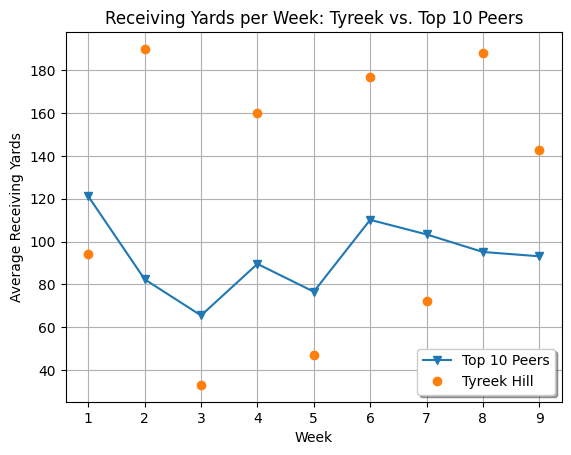

In [68]:
plt.plot(
    'week', 
    'rec_yds', 
    data=top_10_peers_by_week,
    marker='v', 
    label='Top 10 Peers',)
plt.plot(
    'week', 
    'rec_yds', 
    data=df_2022[df_2022['player_name'] == 'Tyreek Hill'],
    marker='o',
    linestyle='',
    label='Tyreek Hill')

plt.xlabel('Week')
plt.ylabel('Average Receiving Yards')
plt.title('Receiving Yards per Week: Tyreek vs. Top 10 Peers')

plt.legend(frameon=1, facecolor='white', framealpha=1, loc="lower right", shadow=True)
plt.grid()

plt.show()

In 2022, Tyreek Hill has had 5 weekly top 5 performances in terms of receiving yards. He has the highest total receiving yards and yards per game. However, it's been mainly feast or famine for Tyreek - he either completely dominates his competition, or performs below expectations in terms of receiving yards and fantasy points. Still, he's a stud and has been fun to watch this year, especially since he is having a career year on a new team.